## LightGBM gradient boosting - half hourly dataset

Note this notebook needs to be run with a 'datascience' virtualenv not fastai env (unless you pip install all imports below into fastai env)


In [1]:
import pandas as pd
import lightgbm as lgb
from numba import jit
import math
import feather
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import numpy as np
import gc
from matplotlib import pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
PATH='../input/merged_data/'

In [4]:
@jit
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        if b < 1:
            b = 0
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

def lgb_smape(preds, df):
    labels = df.get_label()
    labels, preds = np.expm1(np.array(labels)), np.expm1(np.array(preds))
    return 'mape', smape_fast(labels, preds), False

In [5]:
df = pd.read_csv('{0}hh_final_544_ids_735_days.csv'.format(PATH), low_memory=False)

In [6]:
df.head(n=2)

,Unnamed: 0,index,LCLid,energy(kWh/hh),dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,dayIs_month_end,dayIs_month_start,dayIs_quarter_end,dayIs_quarter_start,dayIs_year_end,dayIs_year_start,dayElapsed,delta_minutes,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,humidity,summary,is_bank_holiday,bank_holiday,day,cloudCover,uvIndex,moonPhase,from_sunrise,to_sunset,Afteris_bank_holiday,Beforeis_bank_holiday,stdorToU,Acorn,Acorn_grouped
0,0,2012-02-05 00:00:00,MAC000006,0.042,2012,2,5,5,6,36,False,False,False,False,False,False,1328400000,-360000,1.32,160.0,-0.12,-0.22,1024.21,-4.68,4.35,snow,0.99,Foggy,False,NaN,2012-02-05,0.85,1.0,0.42,454.0,-1017.0,0,-87840,Std,ACORN-Q,Adversity
1,1,2012-02-05 00:00:00,MAC005178,0.561,2012,2,5,5,6,36,False,False,False,False,False,False,1328400000,-360000,1.32,160.0,-0.12,-0.22,1024.21,-4.68,4.35,snow,0.99,Foggy,False,NaN,2012-02-05,0.85,1.0,0.42,454.0,-1017.0,0,-87840,Std,ACORN-E,Affluent


In [7]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [8]:
df.rename(columns={'index': 'day_time'}, inplace=True)

In [9]:
df['day_time'] = pd.to_datetime(df['day_time'], format='%Y-%m-%d %H:%M:%S')

In [10]:
df.dtypes

day_time                 datetime64[ns]
LCLid                            object
energy(kWh/hh)                  float64
dayYear                           int64
dayMonth                          int64
dayWeek                           int64
dayDay                            int64
dayDayofweek                      int64
dayDayofyear                      int64
dayIs_month_end                    bool
dayIs_month_start                  bool
dayIs_quarter_end                  bool
dayIs_quarter_start                bool
dayIs_year_end                     bool
dayIs_year_start                   bool
dayElapsed                        int64
delta_minutes                     int64
visibility                      float64
windBearing                     float64
temperature                     float64
dewPoint                        float64
pressure                        float64
apparentTemperature             float64
windSpeed                       float64
precipType                       object


In [11]:
#replace Nan in this column
df['bank_holiday'] = df['bank_holiday'].fillna('none')

In [12]:
df.fillna(0,inplace=True)

In [13]:
le = preprocessing.LabelEncoder()
df['bank_holiday'] = le.fit_transform(df['bank_holiday'])
df['stdorToU'] = le.fit_transform(df['stdorToU'])
df['Acorn'] = le.fit_transform(df['Acorn'])
df['Acorn_grouped'] = le.fit_transform(df['Acorn_grouped'])
df['precipType'] = le.fit_transform(df['precipType'])
df['summary'] = le.fit_transform(df['summary'])


### T/T split

dataset range is inclusive of '2012-2-5 00:00:00', '2014-2-8 23:30:00'

We want to use the last week as our test set, second last as val set

In [14]:
split_date = pd.datetime(2014,1,26)
test_date = pd.datetime(2014,2,2)

df_train = df.loc[df['day_time'] < split_date ]
mask = (df['day_time'] >= split_date) & (df['day_time'] < test_date)
df_val =  df.loc[mask]
df_test = df.loc[df['day_time'] > test_date]

### LightGBM setup

Using label encode for categoricals

https://lightgbm.readthedocs.io/en/latest/Features.html#optimal-split-for-categorical-features


In [15]:
train_cols = [ 'dayYear','dayMonth','dayWeek','dayDay','dayDayofweek','dayDayofyear','dayIs_month_end','dayIs_month_start','dayIs_quarter_end',
              'dayIs_quarter_start','dayIs_year_end','dayIs_year_start','dayElapsed',
              'visibility','windBearing','temperature','dewPoint','pressure','apparentTemperature',
              'windSpeed','precipType', 'humidity','summary','is_bank_holiday','bank_holiday', 
              'cloudCover','uvIndex','moonPhase','from_sunrise','Afteris_bank_holiday','Beforeis_bank_holiday',
                'stdorToU','Acorn','Acorn_grouped']

In [16]:
cat_vars = ['stdorToU','Acorn','Acorn_grouped', 'bank_holiday', 'precipType', 'summary']

In [17]:
param = {}
param['application'] = 'regression_l2'
param['learning_rate'] = 0.1
param['feature_fraction'] = 0.5
param['bagging_fraction'] = 0.5
param['bagging_freq'] = 1
param['max_depth'] = 5
param['num_threads'] = 4
param['metric'] = 'l2_root'

In [18]:
y_train = df_train["energy(kWh/hh)"]
y_val = df_val["energy(kWh/hh)"]
y_test = df_test["energy(kWh/hh)"]
X_train = df_train[train_cols]
X_val = df_val[train_cols]
X_test = df_test[train_cols]

In [19]:
lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
lgb_val = lgb.Dataset(X_val, label=y_val, free_raw_data=False, reference=lgb_train)

#gbm = lgb.train(param, lgb_train, 1000, valid_sets=[lgb_train,lgb_val], feval=lgb_smape, early_stopping_rounds=10)
gbm = lgb.train(param, lgb_train, 1000, valid_sets=[lgb_train,lgb_val], early_stopping_rounds=10)

[1]	training's rmse: 0.32947	valid_1's rmse: 0.414013
Training until validation scores don't improve for 10 rounds.
[2]	training's rmse: 0.328973	valid_1's rmse: 0.413487
[3]	training's rmse: 0.328515	valid_1's rmse: 0.412965
[4]	training's rmse: 0.32758	valid_1's rmse: 0.411849
[5]	training's rmse: 0.326405	valid_1's rmse: 0.409832
[6]	training's rmse: 0.326134	valid_1's rmse: 0.409542
[7]	training's rmse: 0.325548	valid_1's rmse: 0.408769
[8]	training's rmse: 0.325299	valid_1's rmse: 0.408536
[9]	training's rmse: 0.325141	valid_1's rmse: 0.408426
[10]	training's rmse: 0.325017	valid_1's rmse: 0.408362
[11]	training's rmse: 0.324911	valid_1's rmse: 0.408353
[12]	training's rmse: 0.324338	valid_1's rmse: 0.4077
[13]	training's rmse: 0.323869	valid_1's rmse: 0.407157
[14]	training's rmse: 0.323789	valid_1's rmse: 0.407094
[15]	training's rmse: 0.323017	valid_1's rmse: 0.405764
[16]	training's rmse: 0.322724	valid_1's rmse: 0.40547
[17]	training's rmse: 0.322673	valid_1's rmse: 0.40548
[

In [20]:
gc.collect()

520

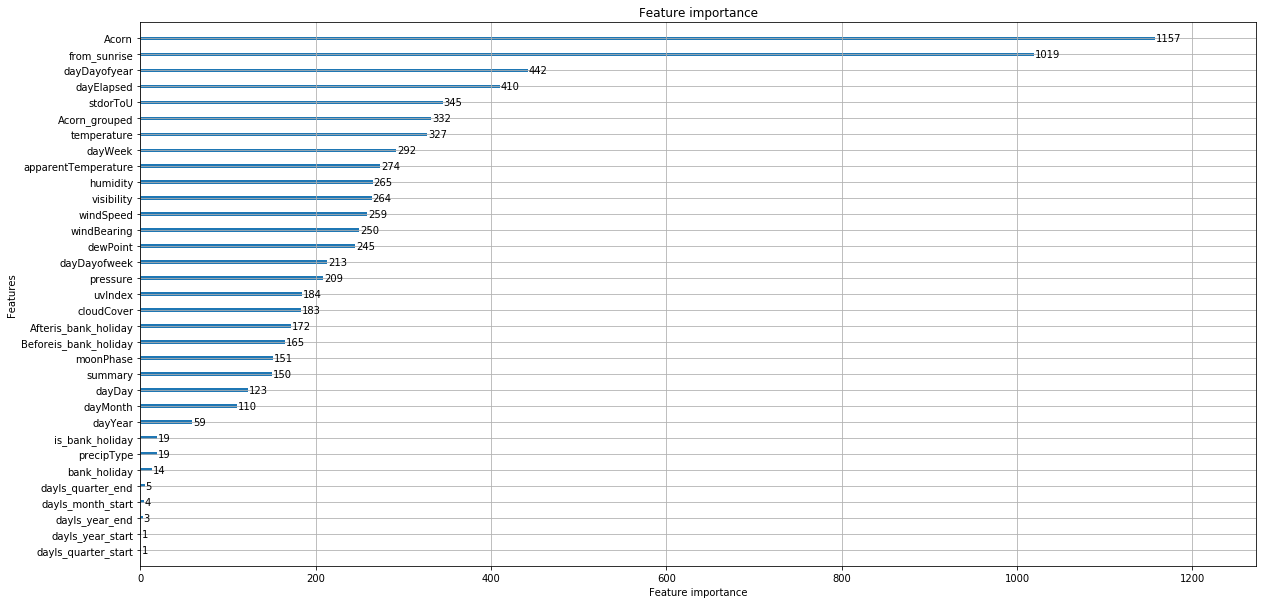

In [21]:
lgb.plot_importance(gbm, figsize=(20, 10))

In [22]:
# save model to file
gbm.save_model('{0}lightgbm/4_4_b_model.txt'.format(PATH))

In [23]:
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [24]:
# eval
print('The rmse of prediction is: {0}'.format(mean_squared_error(y_test, y_pred) ** 0.5))

The rmse of prediction is: 0.37470788223913915


print('rmse: {0}'.format(rmse))

In [25]:
df_test['y_pred'] = y_pred

/home/walle/.virtualenvs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
csv_fn='{0}lightgbm/4_4_b_forecast_GB_hh_preds.csv'.format(PATH)

In [28]:
df_test[['day_time','LCLid','y_pred']] .to_csv(csv_fn, index=False)